In [2]:
library(CiteFuse)
library(scater)
library(SingleCellExperiment)
library(DT)
library(SoupX)
library(UpSetR)
library(caret)
library(cowplot)
library(harmony)
library(scmap)
library(reshape)
library(pheatmap)
library(gridExtra)
library(grid)
library(cowplot)
library(ggrepel)
library(hexbin)
library(SeuratData)
library(SeuratDisk)
library(reticulate)
library(RColorBrewer)

ERROR: Error in library(CiteFuse): there is no package called ‘CiteFuse’


In [3]:
library(ggplot2)
library(tidyverse)
library(Seurat)
library(deMULTIplex)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject



In [6]:
setwd("/lustre/scratch118/malaria/team222/jr35/phd/multiseq_bld/")

In [17]:
bar.ref <- readRDS("data/raw/barcodes1234.rds")
bar.ref <- bar.ref[1:2]

In [18]:
cellids <- read.table("data/raw/cellranger500_count_41440_5736STDY11073697_PfDB52e/filtered_feature_bc_matrix/barcodes.tsv.gz")
cellids <- cellids$V1
cellids <- gsub("-1","",cellids)

In [19]:
# readTable <- MULTIseq.preProcess(R1 = '/lustre/scratch118/malaria/team222/jr35/phd/multiseq_bld/data/processed/multiseq_fq/nf54_7g8_dd2_rd1.fastq', R2 = '/lustre/scratch118/malaria/team222/jr35/phd/multiseq_bld/data/processed/multiseq_fq/nf54_7g8_dd2_rd2.fastq', cellIDs = cellids, cell=c(1,16), umi=c(17,28), tag=c(1,8))
# saveRDS(readTable, "data/processed/readTable_mseq_pp.rds")
readTable <- readRDS("data/processed/readTable_mseq_pp.rds")

In [20]:
head(readTable)

,Cell,UMI,Sample
,<chr>,<chr>,<chr>
7,CAACCTCAGAATCGAT,CTGCGGCAAACT,GGTCTAGT
17,AGTACTGGTTGATGTC,GTATGGACGCAG,GGTCTAGT
32,CACCGTTCAACGTATC,ACCTTATTCAGT,GGTCTAGT
63,GCAGCTGAGTAGGCCA,TTCCACTAGGGA,GGTCTAGT
78,CATTGCCAGAAGCTCG,GACCATAGGACA,GGTCTAGT
94,GTCGCGATCATTACGG,TCCGTGAATACC,GGTCTAGT


In [22]:
head(bar.ref)

[1] "GGTCTAGT" "CTCACAGA"

In [23]:
bar.table <- MULTIseq.align(readTable, cellids, bar.ref)

Loading required package: stringdist


Attaching package: ‘stringdist’


The following object is masked from ‘package:tidyr’:

    extract




[1] "Bucketing cell IDs..."
[1] "Bucketing read tables..."
[1] "Aligning bucket #1..."
[1] "2021-12-10 00:08:28 GMT"
[1] "Done aligning bucket #1..."
Time difference of 9.928366 mins


In [26]:
# saveRDS(bar.table, "data/processed/bar.table.rds")

In [45]:
dim(readRDS("data/processed/bar.table.rds"))

[1] 5438    4

In [46]:
dim(bar.table)

[1] 3405    2

In [25]:
bar.tsne <- barTSNE(bar.table[,1:2])
## Note: Exclude columns 97:98 (assuming 96 barcodes were used) which provide total barcode UMI counts for each cell. 

pdf("envs_scripts/plots/bc.check.pdf")
for (i in 3:ncol(bar.tsne)) {
  g <- ggplot(bar.tsne, aes(x = TSNE1, y = TSNE2, color = bar.tsne[,i])) +
    geom_point() +
    scale_color_gradient(low = "black", high = "red") +
    ggtitle(colnames(bar.tsne)[i]) +
    theme(legend.position = "none") 
  print(g)
}
dev.off()

Performing PCA
Read the 5438 x 2 data matrix successfully!
OpenMP is working. 1 threads.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.44 seconds (sparsity = 0.019830)!
Learning embedding...
Iteration 50: error is 91.572478 (50 iterations in 0.69 seconds)
Iteration 100: error is 71.473625 (50 iterations in 0.71 seconds)
Iteration 150: error is 67.365182 (50 iterations in 0.74 seconds)
Iteration 200: error is 65.670787 (50 iterations in 0.75 seconds)
Iteration 250: error is 64.687256 (50 iterations in 0.77 seconds)
Iteration 300: error is 1.874094 (50 iterations in 0.71 seconds)
Iteration 350: error is 1.413977 (50 iterations in 0.70 seconds)
Iteration 400: error is 1.159319 (50 iterations in 0.70 seconds)
Iteration 450: error is 1.001823 (50 iterations in 0.71 seconds)
Iteration 500: error is 0.899761 (50 iterations in 0.71 seconds)
Iteration 550: error is 0.830694 (50 iterations in 0.72 seconds)
Iteration 600

png 
  2

In [27]:
## Round 1 -----------------------------------------------------------------------------------------------------
## Perform Quantile Sweep
bar.table.full <- bar.table[,1:2]
good.bars <- paste("Bar",1:2,sep="")  # NOTE: In this hypothetical example, barcodes 91-96 were not detected
bar.table <- bar.table.full[, good.bars]  # Remove missing bars and summary columns

In [28]:
good.bars

[1] "Bar1" "Bar2"

In [29]:
bar.table_sweep.list <- list()
n <- 0
for (q in seq(0.01, 0.99, by=0.02)) {
  print(q)
  n <- n + 1
  bar.table_sweep.list[[n]] <- classifyCells(bar.table, q=q)
  names(bar.table_sweep.list)[n] <- paste("q=",q,sep="")
}

[1] 0.01
[1] 0.03
[1] 0.05
[1] 0.07
[1] 0.09
[1] 0.11
[1] 0.13
[1] 0.15
[1] 0.17
[1] 0.19
[1] 0.21
[1] 0.23
[1] 0.25
[1] 0.27
[1] 0.29
[1] 0.31
[1] 0.33
[1] 0.35
[1] 0.37
[1] 0.39
[1] 0.41
[1] 0.43
[1] 0.45
[1] 0.47
[1] 0.49
[1] 0.51
[1] 0.53
[1] 0.55
[1] 0.57
[1] 0.59
[1] 0.61
[1] 0.63
[1] 0.65
[1] 0.67
[1] 0.69
[1] 0.71
[1] 0.73
[1] 0.75
[1] 0.77
[1] 0.79
[1] 0.81
[1] 0.83
[1] 0.85
[1] 0.87
[1] 0.89
[1] 0.91
[1] 0.93
[1] 0.95
[1] 0.97
[1] 0.99


In [30]:
## Identify ideal inter-maxima quantile to set barcode-specific thresholds
threshold.results1 <- findThresh(call.list=bar.table_sweep.list)

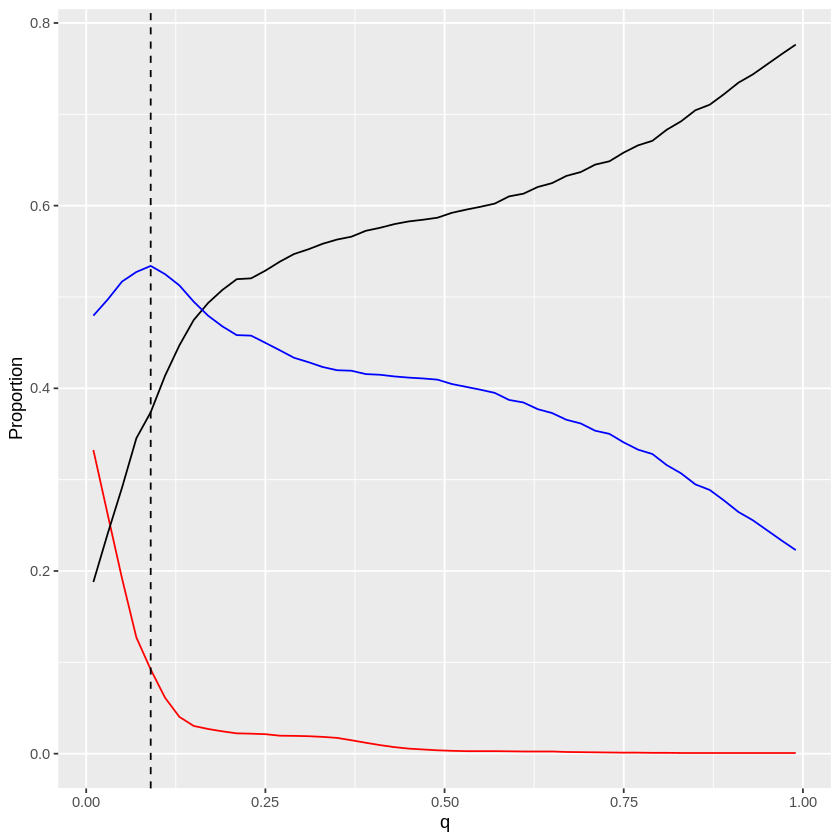

In [31]:
ggplot(data=threshold.results1$res, aes(x=q, y=Proportion, color=Subset)) + geom_line() + theme(legend.position = "none") +
  geom_vline(xintercept=threshold.results1$extrema, lty=2) + scale_color_manual(values=c("red","black","blue"))

In [32]:
## Finalize round 1 classifications, remove negative cells
round1.calls <- classifyCells(bar.table, q=findQ(threshold.results1$res, threshold.results1$extrema))
neg.cells <- names(round1.calls)[which(round1.calls == "Negative")]
bar.table <- bar.table[-which(rownames(bar.table) %in% neg.cells), ]

## Round 2 -----------------------------------------------------------------------------------------------------
bar.table_sweep.list <- list()
n <- 0
for (q in seq(0.01, 0.99, by=0.02)) {
  print(q)
  n <- n + 1
  bar.table_sweep.list[[n]] <- classifyCells(bar.table, q=q)
  names(bar.table_sweep.list)[n] <- paste("q=",q,sep="")
}

threshold.results2 <- findThresh(call.list=bar.table_sweep.list)
round2.calls <- classifyCells(bar.table, q=findQ(threshold.results2$res, threshold.results2$extrema))
neg.cells <- c(neg.cells, names(round2.calls)[which(round2.calls == "Negative")])

## Repeat until all no negative cells remain (usually 3 rounds)...
final.calls <- c(round2.calls, rep("Negative",length(neg.cells)))
names(final.calls) <- c(names(round2.calls),neg.cells)



[1] 0.01
[1] "No threshold found for Bar2..."
[1] 0.03
[1] "No threshold found for Bar2..."
[1] 0.05
[1] "No threshold found for Bar2..."
[1] 0.07
[1] "No threshold found for Bar2..."
[1] 0.09
[1] "No threshold found for Bar2..."
[1] 0.11
[1] "No threshold found for Bar2..."
[1] 0.13
[1] "No threshold found for Bar2..."
[1] 0.15
[1] "No threshold found for Bar2..."
[1] 0.17
[1] "No threshold found for Bar2..."
[1] 0.19
[1] "No threshold found for Bar2..."
[1] 0.21
[1] "No threshold found for Bar2..."
[1] 0.23
[1] "No threshold found for Bar2..."
[1] 0.25
[1] "No threshold found for Bar2..."
[1] 0.27
[1] "No threshold found for Bar2..."
[1] 0.29
[1] "No threshold found for Bar2..."
[1] 0.31
[1] "No threshold found for Bar2..."
[1] 0.33
[1] "No threshold found for Bar2..."
[1] 0.35
[1] "No threshold found for Bar2..."
[1] 0.37
[1] "No threshold found for Bar2..."
[1] 0.39
[1] "No threshold found for Bar2..."
[1] 0.41
[1] "No threshold found for Bar2..."
[1] 0.43
[1] "No threshold found f

In [40]:
addmargins(table(final.calls))

final.calls
    Bar1     Bar2  Doublet Negative      Sum 
    1385      624      590     3645     6244 

In [33]:
## Perform semi-supervised negative cell reclassification
reclass.cells <- findReclassCells(bar.table.full, names(final.calls)[which(final.calls=="Negative")])
reclass.res <- rescueCells(bar.table.full, final.calls, reclass.cells)


[1] "Normalizing barode data..."
[1] "Pre-allocating data structures..."


Warning message:
“non-unique values when setting 'row.names': ‘AAACGAATCTCGGTCT’, ‘AAACGCTCAACGTTAC’, ‘AAACGCTTCTCAGAAC’, ‘AAAGGGCAGGACGCTA’, ‘AAAGGGCGTGTACAGG’, ‘AAAGTCCCACAACATC’, ‘AAAGTGATCACTGAAC’, ‘AAAGTGATCCTCTGCA’, ‘AACAAAGAGTACCATC’, ‘AACAAAGAGTGCGTCC’, ‘AACAAAGCACCCTTAC’, ‘AACAACCAGGATTCCT’, ‘AACAAGACAGCACAAG’, ‘AACAGGGCACGCCACA’, ‘AACAGGGCATGAAAGT’, ‘AACAGGGGTACCGTCG’, ‘AACCCAATCAGCTGTA’, ‘AACCTGAGTTGAGAGC’, ‘AACCTTTCACGAAAGC’, ‘AACGTCAGTCTCCTGT’, ‘AACGTCATCCTGGGAC’, ‘AAGACTCAGATACATG’, ‘AAGCATCAGGTCACTT’, ‘AAGCGAGGTGTCACAT’, ‘AAGCGAGTCACAAGAA’, ‘AAGGAATTCCGTGTCT’, ‘AAGGTAACAGTTGTCA’, ‘AAGGTAAGTCTTCGAA’, ‘AAGTACCGTCAACACT’, ‘AAGTGAATCTTCTGTA’, ‘AATCACGAGGTTCAGG’, ‘AATCACGGTATGGAAT’, ‘AATGAAGGTTTCAGAC’, ‘AATGACCTCCAAGCAT’, ‘AATGCCAGTCAGACTT’, ‘AATGCCATCTGAGAAA’, ‘AATGGAATCCGGTTCT’, ‘AATGGCTCACTCCCTA’, ‘AATTCCTTCCTACCGT’, ‘AATTTCCAGGTGCCAA’, ‘ACAAAGAGTTTACGAC’, ‘ACAACCAAGACGTCGA’, ‘ACAGAAACATTAAGCC’, ‘ACAGAAAGTGTGAATA’, ‘ACATCGATCGTCGACG’, ‘ACATGCACACGTAGTT’, ‘ACATGCAGTATCCTTT’

ERROR: Error in `.rowNamesDF<-`(x, value = value): duplicate 'row.names' are not allowed


In [34]:
## Visualize Results
ggplot(reclass.res[-1, ], aes(x=ClassStability, y=MatchRate_mean)) + 
    geom_point() + xlim(c(nrow(reclass.res)-1,1)) + 
    ylim(c(0,1.05)) +
    geom_errorbar(aes(ymin=MatchRate_mean-MatchRate_sd, ymax=MatchRate_mean+MatchRate_sd), width=.1) +
    geom_hline(yintercept = reclass.res$MatchRate_mean[1], color="red") +
    geom_hline(yintercept = reclass.res$MatchRate_mean[1]+3*reclass.res$MatchRate_sd[1], color="red",lty=2) +
    geom_hline(yintercept = reclass.res$MatchRate_mean[1]-3*reclass.res$MatchRate_sd[1], color="red",lty=2)


ERROR: Error in ggplot(reclass.res[-1, ], aes(x = ClassStability, y = MatchRate_mean)): object 'reclass.res' not found


In [ ]:
## Finalize negative cell rescue results
final.calls.rescued <- final.calls
rescue.ind <- which(reclass.cells$ClassStability >= 16) ## Note: Value will be dataset-specific
final.calls.rescued[rownames(reclass.cells)[rescue.ind]] <- reclass.cells$Reclassification[rescue.ind]


In [7]:
nf54_dd2_3d7_umi = Read10X("data/raw/cellranger500_count_41440_5736STDY11073697_PfDB52e/filtered_feature_bc_matrix/")


In [8]:
str(nf54_dd2_3d7_umi)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:9186352] 19 21 22 23 24 26 29 30 33 34 ...
  ..@ p       : int [1:5439] 0 2329 2875 5397 8159 10102 10659 13241 13605 15280 ...
  ..@ Dim     : int [1:2] 5390 5438
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:5390] "PF3D7_0100100" "PF3D7_0100200" "PF3D7_0100300" "PF3D7_0100400" ...
  .. ..$ : chr [1:5438] "AAACCCAAGGTCACAG-1" "AAACCCACAAGACAAT-1" "AAACCCAGTTAAGGAT-1" "AAACGAAAGACTCCGC-1" ...
  ..@ x       : num [1:9186352] 1 1 1 2 2 12 1 1 2 1 ...
  ..@ factors : list()


In [9]:
bar.table.orig <- readRDS("data/processed/bar.table.rds")

In [10]:
bar.table.orig %>% select(Bar1, Bar2) %>% rownames_to_column("cell_bc") %>% mutate(across(cell_bc, ~paste0(.,"-1"))) %>% column_to_rownames("cell_bc") %>% t(.)

,AAACCCAAGGTCACAG-1,AAACCCACAAGACAAT-1,AAACCCAGTTAAGGAT-1,AAACGAAAGACTCCGC-1,AAACGAAGTAAGATAC-1,AAACGAAGTTCTGAGT-1,AAACGAATCAGCGGAA-1,AAACGAATCTCGGTCT-1,AAACGCTAGAGAAGGT-1,AAACGCTAGCGAGTAC-1,⋯,TTTGGTTCAACTGCCG-1,TTTGGTTCATGCCATA-1,TTTGGTTGTATTGACC-1,TTTGGTTGTCTGTAGT-1,TTTGGTTTCACTTGTT-1,TTTGTTGAGATAGCAT-1,TTTGTTGAGTCAGAGC-1,TTTGTTGGTAGCGATG-1,TTTGTTGTCAGTGTTG-1,TTTGTTGTCGTTCATT-1
Bar1,1658,1593,2811,1555,1547,1489,1502,1271,1719,1836,⋯,1365,1411,1548,1198,1650,1355,1257,1471,1630,1663
Bar2,29,79,61,47,37,108,29,64,32,28,⋯,31,118,162,92,46,26,87,95,25,34


In [11]:
bar.table.orig.t <- bar.table.orig %>% select(Bar1, Bar2) %>% rownames_to_column("cell_bc") %>% mutate(across(cell_bc, ~paste0(.,"-1"))) %>% column_to_rownames("cell_bc") %>% t(.)

In [12]:
colnames(nf54_dd2_3d7_umi) %>% length()

[1] 5438

In [ ]:
# str(readRDS("data/raw/seurat_htodemux_training_dset/pbmc_hto_mtx.rds"))

In [14]:
# Select cell barcodes detected by both RNA and HTO In the example datasets we have already
# filtered the cells for you, but perform this step for clarity.
joint.bcs <- intersect(colnames(nf54_dd2_3d7_umi), colnames(bar.table.orig.t))

In [15]:
# Subset RNA and HTO counts by joint cell barcodes
nf54_dd2_3d7_umi <- nf54_dd2_3d7_umi[, joint.bcs]
bar.table.orig.t <- as.matrix(bar.table.orig.t[, joint.bcs])

In [16]:
# Confirm that the HTO have the correct names
rownames(bar.table.orig.t) 

[1] "Bar1" "Bar2"

In [17]:
# Setup Seurat object
nf54_dd2_3d7_seu <- CreateSeuratObject(counts = nf54_dd2_3d7_umi)

# Normalize RNA data with log normalization
nf54_dd2_3d7_seu <- NormalizeData(nf54_dd2_3d7_seu)
# Find and scale variable features
nf54_dd2_3d7_seu <- FindVariableFeatures(nf54_dd2_3d7_seu, selection.method = "mean.var.plot")
nf54_dd2_3d7_seu <- ScaleData(nf54_dd2_3d7_seu, features = VariableFeatures(nf54_dd2_3d7_seu))

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Centering and scaling data matrix



In [18]:
# Add HTO data as a new assay independent from RNA
nf54_dd2_3d7_seu[["LMO"]] <- CreateAssayObject(counts = bar.table.orig.t)
# Normalize HTO data, here we use centered log-ratio (CLR) transformation
nf54_dd2_3d7_seu <- NormalizeData(nf54_dd2_3d7_seu, assay = "LMO", normalization.method = "CLR")

Normalizing across features



In [19]:


# If you have a very large dataset we suggest using k_function = 'clara'. This is a k-medoid
# clustering function for large applications You can also play with additional parameters (see
# documentation for HTODemux()) to adjust the threshold for classification Here we are using the
# default settings
nf54_dd2_3d7_seu <- HTODemux(nf54_dd2_3d7_seu, assay = "LMO", positive.quantile = 0.99)

$start.arg
$start.arg$size
[1] 9.339475

$start.arg$mu
[1] 1457.115


$fix.arg
NULL



Cutoff for Bar1 : 3183 reads



$start.arg
$start.arg$size
[1] 20.65153

$start.arg$mu
[1] 31.14587


$fix.arg
NULL



Cutoff for Bar2 : 58 reads



In [20]:
# Global classification results
table(nf54_dd2_3d7_seu$LMO_classification.global)


 Doublet Negative  Singlet 
      21     3237     2180 

Picking joint bandwidth of 0.0117

Picking joint bandwidth of 0.0294



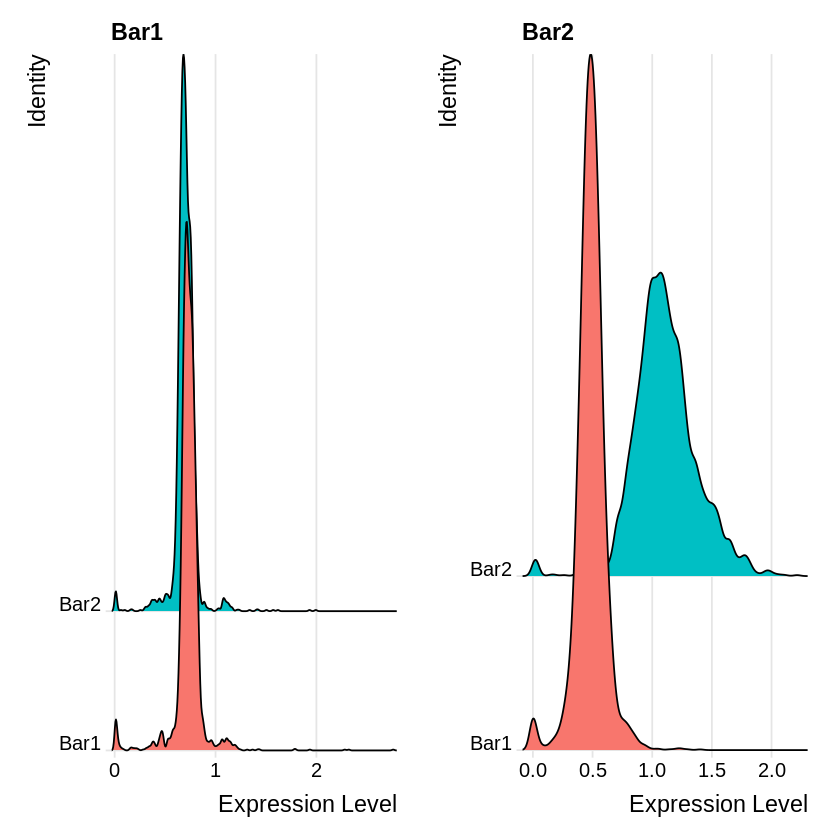

In [21]:
# Group cells based on the max HTO signal
Idents(nf54_dd2_3d7_seu) <- "LMO_maxID"
RidgePlot(nf54_dd2_3d7_seu, assay = "LMO", features = rownames(nf54_dd2_3d7_seu[["LMO"]])[1:2], ncol = 2)

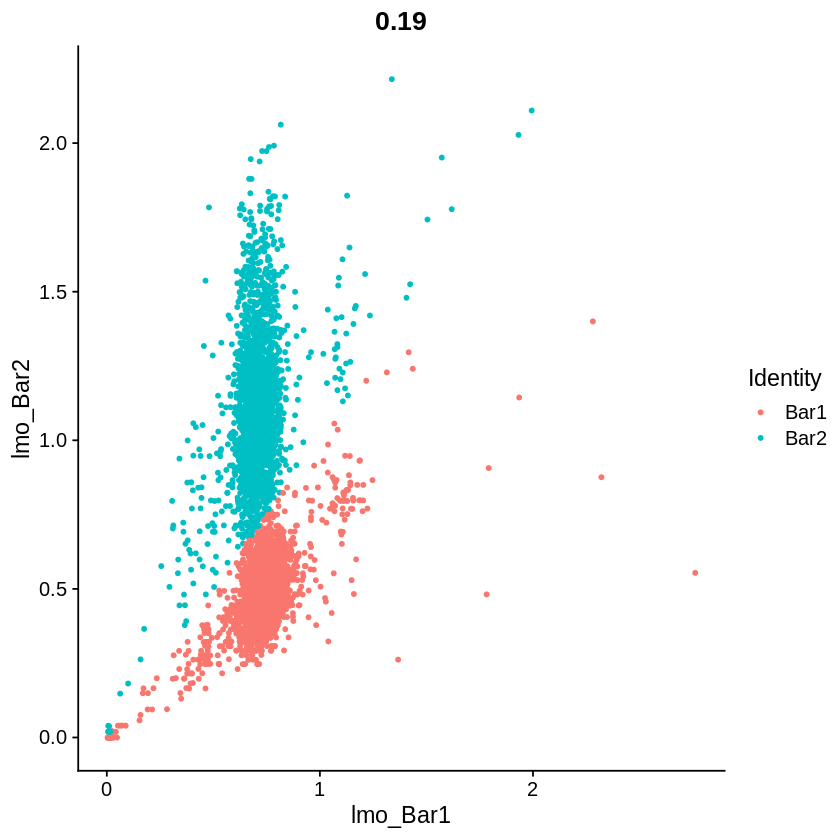

In [22]:
FeatureScatter(nf54_dd2_3d7_seu, feature1 = "lmo_Bar1", feature2 = "lmo_Bar2")


In [134]:
nf54_dd2_3d7_seu@meta.data %>% glimpse

Rows: 5,438
Columns: 11
$ orig.ident                <fct> SeuratProject, SeuratProject, SeuratProject,…
$ nCount_RNA                <dbl> 9881, 1091, 11186, 13472, 5154, 1059, 10710,…
$ nFeature_RNA              <int> 2329, 546, 2522, 2762, 1943, 557, 2582, 364,…
$ nCount_LMO                <dbl> 1687, 1672, 2872, 1602, 1584, 1597, 1531, 13…
$ nFeature_LMO              <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,…
$ LMO_maxID                 <chr> "Bar1", "Bar2", "Bar1", "Bar1", "Bar1", "Bar…
$ LMO_secondID              <chr> "Bar2", "Bar1", "Bar2", "Bar2", "Bar2", "Bar…
$ LMO_margin                <dbl> 0.33142853, 0.18032081, 0.31311905, 0.091802…
$ LMO_classification        <chr> "Negative", "Bar2", "Bar1", "Negative", "Neg…
$ LMO_classification.global <chr> "Negative", "Singlet", "Singlet", "Negative"…
$ hash.ID                   <fct> Negative, Bar2, Bar1, Negative, Negative, Ba…


Saving 6.67 x 6.67 in image



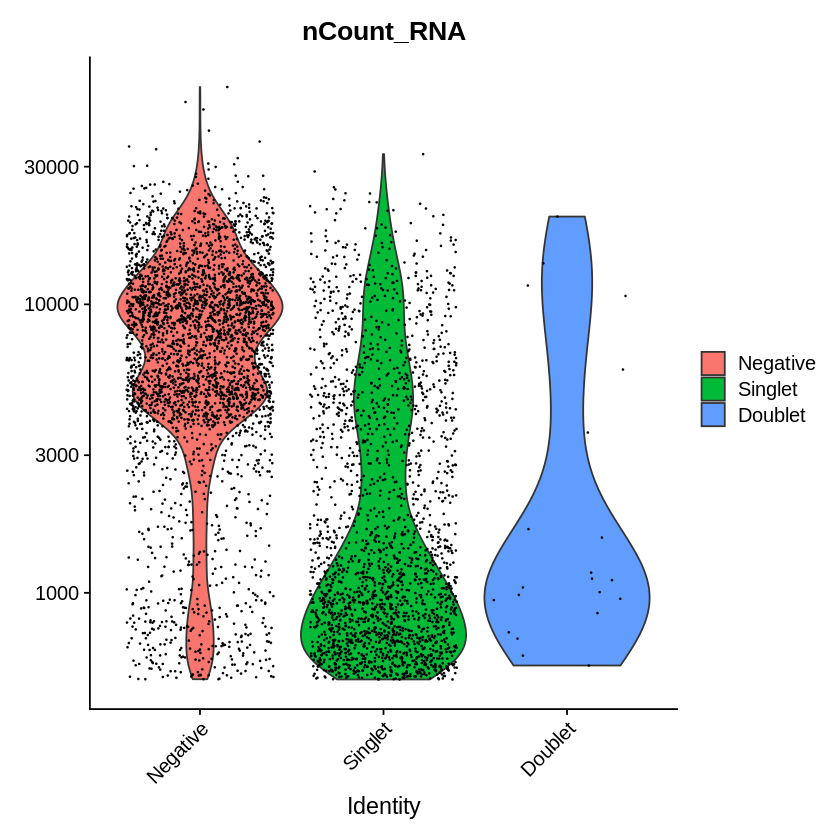

In [24]:


Idents(nf54_dd2_3d7_seu) <- "LMO_classification.global"
VlnPlot(nf54_dd2_3d7_seu, features = "nCount_RNA", pt.size = 0.1, log = TRUE)
ggsave("plots/read_count_by_dbltstatus.png")

In [ ]:
# # First, we will remove negative cells from the object
# nf54_dd2_3d7_seu.subset <- subset(nf54_dd2_3d7_seu, idents = "Negative", invert = TRUE)

Warning message:
“Adding a command log without an assay associated with it”
Saving 6.67 x 6.67 in image



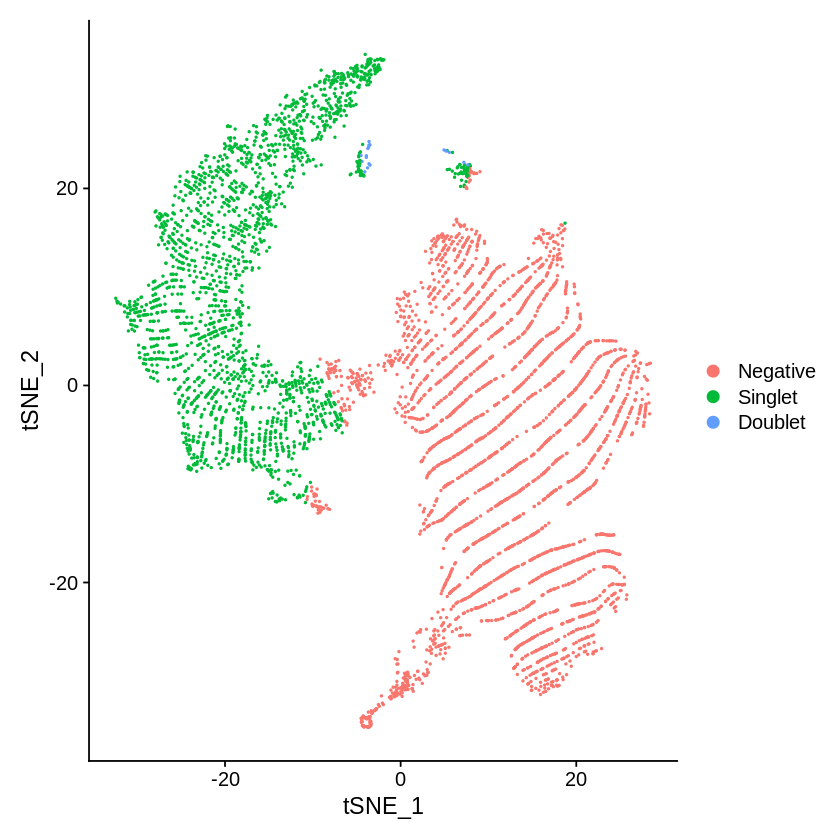

In [26]:
# Calculate a distance matrix using HTO
hto.dist.mtx <- as.matrix(dist(t(GetAssayData(object = nf54_dd2_3d7_seu, assay = "LMO"))))

# Calculate tSNE embeddings with a distance matrix
nf54_dd2_3d7_seu <- RunTSNE(nf54_dd2_3d7_seu, distance.matrix = hto.dist.mtx, perplexity = 100)
DimPlot(nf54_dd2_3d7_seu)
ggsave("plots/nf54_dd2_3d7_seu_tsne.png")

In [27]:
##Add souporcell genotypes metadata to seurat
soupo_gtypes <- read_delim("data/processed/soupc_results/clusters.tsv", delim = '\t', col_names = T) %>% 
  column_to_rownames("barcode")%>%
  dplyr::mutate("gtypes" = case_when(status == "doublet" ~ "Doublet",
                                     status == "unassigned" ~ "Negative",
                                     assignment == "0" ~ "0",
                                     assignment == "1" ~ "1",
                                     assignment == "2" ~ "2")) %>%
  select("gtypes") 

Rows: 5438 Columns: 8

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): barcode, status, assignment
dbl (5): log_prob_singleton, log_prob_doublet, cluster0, cluster1, cluster2


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [28]:
nf54_dd2_3d7_seu <- AddMetaData(nf54_dd2_3d7_seu,soupo_gtypes)

In [29]:
nf54_dd2_3d7_seu@meta.data %>% dplyr::count(gtypes, LMO_classification)

gtypes,LMO_classification,n
<chr>,<chr>,<int>
0,Bar1,8
0,Bar1_Bar2,16
0,Bar2,1790
0,Negative,169
1,Bar1,39
1,Bar1_Bar2,3
1,Bar2,137
1,Negative,2989
2,Bar1,2


Saving 6.67 x 6.67 in image



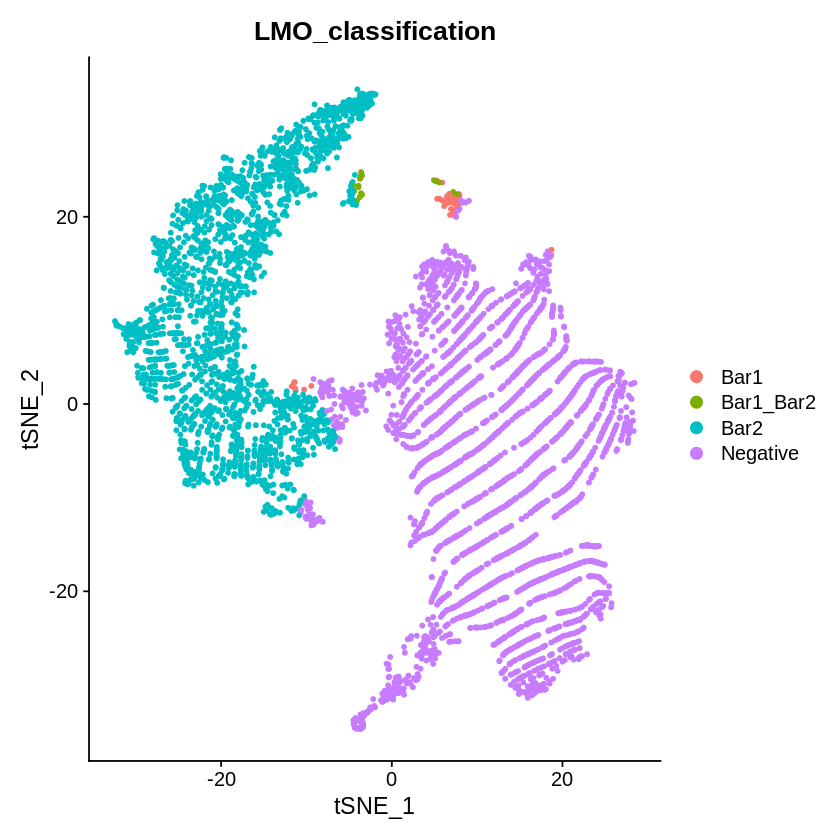

In [31]:
DimPlot(nf54_dd2_3d7_seu, group.by = 'LMO_classification', pt.size = 1)
ggsave("plots/nf54_dd2_3d7_seu_tsne_by_bar.png")

Saving 6.67 x 6.67 in image



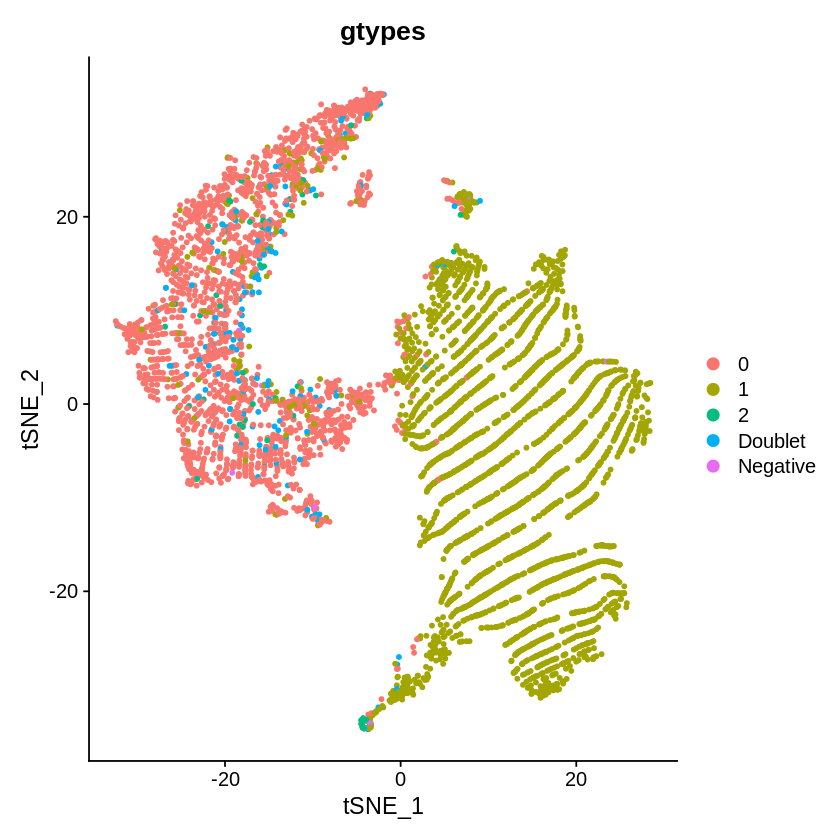

In [32]:
DimPlot(nf54_dd2_3d7_seu, group.by = 'gtypes', pt.size = 1)
ggsave("plots/nf54_dd2_3d7_seu_tsne_by_soupog.png")

Saving 6.67 x 6.67 in image



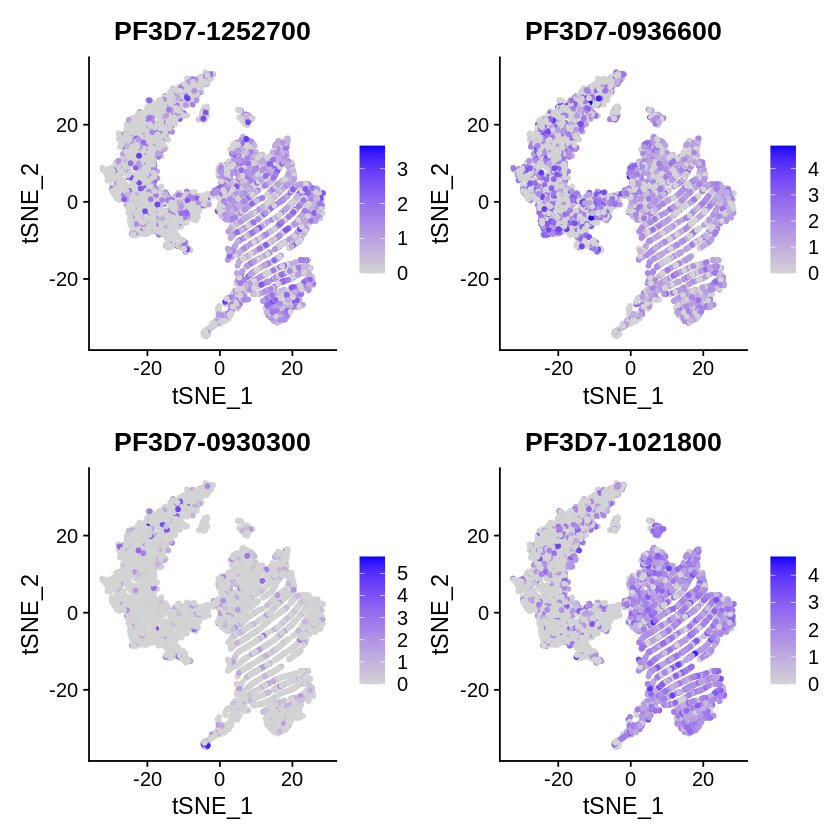

In [37]:
FeaturePlot(nf54_dd2_3d7_seu, features = c('PF3D7-1252700', 'PF3D7-0936600', 'PF3D7-0930300', 'PF3D7-1021800'), pt.size = 1)
ggsave("plots/nf54_dd2_3d7_seu_tsne_by_markers.png")